# Recommendation System with `PySpark` and `Watson Machine Learning`


We're going to build a Collaborative Filtering based Recommendation System with Apache Spark. Then we'll consume this model in a [`python Flask` application](https://console.bluemix.net/catalog/starters/python-flask) on IBM Cloud. 
_________

We'll use the the Spark implementation of the [Alternating Least Squares](https://spark.apache.org/docs/2.2.0/ml-collaborative-filtering.html) algorithm and then **save and deploy our model** with [Watson Machine Learning](https://dataplatform.ibm.com/docs/content/analyze-data/ml-overview.html?audience=wdp&context=analytics) using the [WML Python Client](https://dataplatform.ibm.com/docs/content/analyze-data/pm_service_client_library.html#client-libraries). 

_________

## [I. The Data](#data)
Inspect the data 
## [II. The Model](#model)
Build and compare models
## [III. Watson Machine Learning](#wml)
Save and deploy the model for Watson Machine Learning
________


### I. The Data

In [4]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(sc, '***', '***')
pc = project.project_context


In [5]:
# get the file url
url = project.get_file_url("user-item-interactions.csv")

# spark dataframe
spark = SparkSession.builder.getOrCreate()
df = spark.read.format('csv')\
  .option('header', 'true')\
  .load(url)
df.show(5)

+---+----------+--------------------+--------------------+
|_c0|article_id|               title|               email|
+---+----------+--------------------+--------------------+
|  0|    1430.0|using pixiedust f...|ef5f11f77ba020cd3...|
|  1|    1314.0|healthcare python...|083cbdfa93c8444be...|
|  2|    1429.0|use deep learning...|b96a4f2e92d857203...|
|  3|    1338.0|ml optimization u...|06485706b34a5c9bf...|
|  4|    1276.0|deploy your pytho...|f01220c46fc92c6e6...|
+---+----------+--------------------+--------------------+
only showing top 5 rows



In [6]:
# check the schema
df = df[['article_id', 'title', 'email']]
df = df.na.drop()
df.printSchema()

root
 |-- article_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- email: string (nullable = true)



In [7]:
# check for NAN values
from pyspark.sql.functions import isnan, when, count, col

# check for nulls
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+----------+-----+-----+
|article_id|title|email|
+----------+-----+-----+
|         0|    0|    0|
+----------+-----+-----+



In [8]:
# pivot the data to get the counts
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol='email', outputCol = 'indexed_email', handleInvalid='skip').fit(df)

new_df = indexer.transform(df)

piv = new_df.groupby("indexed_email", "article_id").count().cache()
piv.show(10)

+-------------+----------+-----+
|indexed_email|article_id|count|
+-------------+----------+-----+
|       1165.0|     788.0|    1|
|        383.0|     680.0|    1|
|       5027.0|     427.0|    1|
|        352.0|     369.0|    1|
|         82.0|     314.0|    4|
|         75.0|    1151.0|    1|
|         15.0|    1162.0|    2|
|       1575.0|     645.0|    1|
|        849.0|     173.0|    1|
|        251.0|     939.0|    1|
+-------------+----------+-----+
only showing top 10 rows



In [7]:
new_df.show(3)

+----------+--------------------+--------------------+-------------+
|article_id|               title|               email|indexed_email|
+----------+--------------------+--------------------+-------------+
|    1430.0|using pixiedust f...|ef5f11f77ba020cd3...|        154.0|
|    1314.0|healthcare python...|083cbdfa93c8444be...|       1674.0|
|    1429.0|use deep learning...|b96a4f2e92d857203...|         44.0|
+----------+--------------------+--------------------+-------------+
only showing top 3 rows



In [8]:
# take a look at the distribution of the number of article interactions per user

import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
import numpy as np

vals = np.array(piv.select("count").collect())
v = [a[0] for a in vals]


count    33011.000000
mean         1.367999
std          1.180083
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         42.000000
dtype: float64


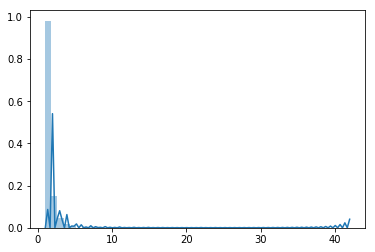

In [9]:
import pandas as pd
print(pd.Series(v).describe())
sns.distplot(v)

### II. The Model

In [10]:
from pyspark.ml.feature import QuantileDiscretizer
from pyspark.sql.types import DoubleType, IntegerType
piv = piv.withColumn('count', piv['count'].cast(DoubleType()))
piv = piv.withColumn('article_id', piv['article_id'].cast(IntegerType()))
discretizer = QuantileDiscretizer(numBuckets=5, inputCol="count", outputCol="result")

In [11]:
# train test split

# drop the nulls in the count section and split the data 
piv = piv.na.drop()
trainingDataRDD, testingDataRDD = piv.rdd.randomSplit([7.0, 3.0], seed=0)
trainingData = spark.createDataFrame(trainingDataRDD)
testingData = spark.createDataFrame(testingDataRDD)

In [12]:
# modelling 

# we'll test different architectures 
# different ranks, different errors , different regularization params, iterations

from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import QuantileDiscretizer
import math

results = {}

seed = 5
iterations = [5, 10, 18]
regularization_parameters = [0.01,0.1]
ranks = [8,10,16]
errors = [0]*len(regularization_parameters)*len(ranks)*len(iterations)
err = 0

min_error = float('inf')
best_rank = -1
best_iteration = -1
for rank in ranks:
    for regularization in regularization_parameters:
        for iteration in iterations:
            
            # instantiate the model
            als = ALS(rank=rank, maxIter=iteration, regParam=regularization, userCol="indexed_email", itemCol="article_id", ratingCol="count", implicitPrefs=True, nonnegative=True)
            
            # fit the model
            model = als.fit(trainingData)
            
            # remove Nan predicitons
            
            # Evaluate the model by computing the RMSE on the test data
            predictions = model.transform(testingData)
            evaluator = RegressionEvaluator(metricName="rmse", labelCol="count",
                                predictionCol="prediction")

            # get the error
            # drop the nan predictions for unseen data during testing
            error = evaluator.evaluate(predictions.na.drop())
            predictions.show(3)
            errors[err] = error
            err += 1
            # store the results
            results["model-{}-{}-{}".format(rank, iteration, regularization)] = error
            
            print('For rank {}, iterations {}, regularization {} the RMSE is {}'.format(rank, iteration, regularization, error))
            if error < min_error:
                min_error = error
                best_rank = rank

+-------------+----------+-----+-----------+
|indexed_email|article_id|count| prediction|
+-------------+----------+-----+-----------+
|         95.0|       463|  2.0|0.028795276|
|        613.0|       833|  1.0|  0.1333396|
|        139.0|       833|  1.0|   0.171878|
+-------------+----------+-----+-----------+
only showing top 3 rows

For rank 8, iterations 5, regularization 0.01 the RMSE is 1.7923962811078646
+-------------+----------+-----+------------+
|indexed_email|article_id|count|  prediction|
+-------------+----------+-----+------------+
|         95.0|       463|  2.0|  0.02346854|
|       3607.0|       833|  1.0|0.0059292275|
|          4.0|       833|  2.0|  0.29947022|
+-------------+----------+-----+------------+
only showing top 3 rows

For rank 8, iterations 10, regularization 0.01 the RMSE is 1.785164459358515
+-------------+----------+-----+-----------+
|indexed_email|article_id|count| prediction|
+-------------+----------+-----+-----------+
|         95.0|       46

Now that we've seen which model has the best performance, we're going to build a pipeline and save and deploy the model. 

We'll use `rank 16`, `iterations 18`, `regularlization of .1`

Now that we've decided on some of the parameters, we can train/test on the full dataset. 

In [22]:
# let's create some testing data
training_RDD, test_RDD = piv.randomSplit([7.0, 3.0], seed=0)

# instantiate
als = ALS(rank=16, maxIter=18, regParam=.1, userCol="indexed_email", itemCol="article_id", ratingCol="count", implicitPrefs=True, nonnegative=True)
complete_model = als.fit(training_RDD)

In [44]:
# let's test the model
# test_for_predict_RDD = test_RDD.rdd.map(lambda x: (x[0], x[1]))

from pyspark.ml.evaluation import RegressionEvaluator
predictions = complete_model.transform(test_RDD).rdd.map(lambda r: ((r[0], r[1]), r[2]))
rates_and_preds = test_RDD.rdd.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)
error = math.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
# evaluator = RegressionEvaluator(metricName="rmse", labelCol="count",
#                                 predictionCol="prediction")
# rmse = evaluator.evaluate(predictions)
# print("Root-mean-square error = " + str(rmse))

In [47]:
rates_and_preds.take(10)

[((688, 1422), (1.0, 1.0)),
 ((1, 1181), (3.0, 3.0)),
 ((145, 237), (2.0, 2.0)),
 ((1377, 173), (1.0, 1.0)),
 ((2183, 43), (1.0, 1.0)),
 ((569.0, 213), (1.0, 1.0)),
 ((182.0, 1436), (1.0, 1.0)),
 ((742.0, 1180), (1.0, 1.0)),
 ((353.0, 1405), (1.0, 1.0)),
 ((218, 784), (1.0, 1.0))]

In [40]:
# predictions.take(10)
error

0.0

In [ ]:
print("The final Test RMSE is {}".format(error))

In [ ]:
predictions.take(4)

**Bringing it all together**

In [13]:
# import the tools we need
from pyspark.ml.feature import SQLTransformer
from pyspark.ml.feature import QuantileDiscretizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml.recommendation import ALS
from pyspark.ml import Pipeline, Model


# group and get the ratings data, convert dtypes
sql_transform_ratings = SQLTransformer(
    statement="SELECT indexed_email, cast(article_id as double), cast( count(article_id) as double) as rating FROM __THIS__ GROUP BY indexed_email, article_id")

# bin the data
discretizer = QuantileDiscretizer(numBuckets=5, inputCol="rating", outputCol="binned")

# convert the dtypes and drop nulls
sql_transform_dtypes = sql_transform_1 = SQLTransformer(
    statement="SELECT cast(indexed_email as int), cast(article_id as int), cast(rating as double), cast(binned as double) FROM __THIS__ WHERE indexed_email IS NOT NULL and article_id IS NOT NULL and binned IS NOT NULL")


# fit ALS based collaborative filtering model
als = ALS(maxIter=10, regParam = .1, userCol = "indexed_email", itemCol = "article_id", ratingCol= "binned", implicitPrefs=True, nonnegative=True)


In [14]:
# the preprocessing step
preprocessor_pipe = Pipeline(stages = [sql_transform_ratings, discretizer, sql_transform_dtypes, als])

In [15]:
ml_df = new_df.na.drop()
als_fit = preprocessor_pipe.fit(ml_df)
new_df = als_fit.transform(ml_df)

In [16]:
new_df.show(3)

+-------------+----------+------+------+-----------+
|indexed_email|article_id|rating|binned| prediction|
+-------------+----------+------+------+-----------+
|           92|       463|   1.0|   1.0|0.042622246|
|         1574|       463|   1.0|   1.0|0.008220874|
|         1769|       463|   1.0|   1.0|0.008684835|
+-------------+----------+------+------+-----------+
only showing top 3 rows



##### Bringing it together 

### III. Watson Machine Learning

1. Build a pipeline
2. Save and deploy the pipeline 
3. Configure the continuous learning system? 

In [17]:
# build the pipeline
# input a df we'll need to 
# !pip install watson-machine-learning-client --upgrade
import json
import watson_machine_learning_client

In [18]:
# add your credentials
wml_credentials = {
  "url": "https://ibm-watson-ml.mybluemix.net",
  "username": "***",
  "password": "***",
  "instance_id": "***"
}

In [19]:
# connect to the client
from watson_machine_learning_client import WatsonMachineLearningAPIClient
from watson_machine_learning_client.metanames import MetaNames 

# make connection
client = WatsonMachineLearningAPIClient(wml_credentials)
# get your instance details
instance_details = client.service_instance.get_details()

# print(json.dumps(instance_details, indent=2))

In [26]:
# metaprops
from watson_machine_learning_client.metanames import MetaNames 
model_props = {client.repository.ModelMetaNames.AUTHOR_NAME: "Adam Massachi - IBM", 
               client.repository.ModelMetaNames.AUTHOR_EMAIL: "adam.massachi@ibm.com", 
               client.repository.ModelMetaNames.NAME: "UdacityCollabRecSystem-UserItem",
               MetaNames.LABEL_FIELD: "rating"}
# store the model
published_model = client.repository.store_model(model=als_fit, pipeline=preprocessor_pipe, meta_props=model_props, training_data=new_df.select("indexed_email",  "article_id", "rating", "binned"))

In [27]:
# get the detials to deploy
published_model_uid = client.repository.get_model_uid(published_model)
model_details = client.repository.get_details(published_model_uid)


In [34]:
details = client.repository.list_models()

------------------------------------  ------------------------------------  ------------------------  -----------------
GUID                                  NAME                                  CREATED                   FRAMEWORK
e89ac770-1eda-425d-a882-fdedc9729a78  UdacityCollabRecSystem-Collaborators  2018-04-26T17:04:59.688Z  mllib-2.1
1c227989-44cd-421d-963e-fdf985c56ff2  NOPO_KERAS                            2018-05-09T00:00:39.622Z  tensorflow-1.5
d3ab930b-416a-49e0-9218-1c6b177afa9a  MNIST best model                      2018-05-16T18:56:27.772Z  tensorflow-1.5
9b113a2e-1bdc-4564-995e-541c3550eef4  MNIST best model                      2018-05-16T20:54:49.903Z  tensorflow-1.5
d8a4d579-a662-4330-b2cf-89e0fce32897  HPO-FashionMNIST-EA                   2018-05-17T15:51:24.424Z  tensorflow-1.5
eb4260b0-114f-4d87-8080-23148081685f  UdacityCollabRecSystem-Collaborators  2018-05-22T22:02:27.308Z  mllib-2.1
a04de256-45d7-47cb-a6b0-d842605e424d  SPSS_DEMO                             

In [43]:
# deploy the model
try:
    dep = client.deployments.create('7ba02350-c628-409e-969b-93a50a550b3d', name="spark_rec_system_deployed_2", description="REC_SYSTEM_DEPLOY_2")
except:
    print("Waiting for saved model ...")



#######################################################################################

Synchronous deployment creation for uid: '9f5e422a-53c4-4516-91f2-69a48d383bf2' started

#######################################################################################


INITIALIZING
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='9f5e422a-53c4-4516-91f2-69a48d383bf2'
------------------------------------------------------------------------------------------------




In [44]:
# get the scoring url for use in the app
scoring_url = dep['entity']['scoring_url']
print(scoring_url)

https://ibm-watson-ml.mybluemix.net/v3/wml_instances/0aa4c97b-16bb-4bcc-afc7-58ed0c0709e7/published_models/7ba02350-c628-409e-969b-93a50a550b3d/deployments/9f5e422a-53c4-4516-91f2-69a48d383bf2/online


In [45]:
# score a record
input_json = {
    'fields': ["indexed_email", "article_id"],
    'values': [[1165,788]]}

In [46]:
# score
client.deployments.score(scoring_url, input_json)

{u'fields': [u'indexed_email',
  u'article_id',
  u'rating',
  u'binned',
  u'prediction'],
 u'values': [[1165, 788, 1.0, 1.0, 0.0935187041759491]]}

In [48]:
all_articles = df.toPandas()['article_id'].unique()
import operator

# Let's write a function that will return all of the ranked article_ids
def getUserRecommendations(user_id):
    """
    Get the article scores for every user, sort them, and serve them
    """
    
    # create a request
    input_json = {
    'fields': ["indexed_email", "article_id"],
    'values': [[user_id,float(article_id)] for article_id in all_articles]}
    
    
    # score
    predictions = client.deployments.score(scoring_url, input_json)
    
    # we are only interested in the prediction and article_id
    vals = [(p[1], p[-1]) for p in predictions['values']]
    
    # sort the tuples
    vals.sort(key=operator.itemgetter(1))
    
    return list(reversed(vals[-5:]))

In [49]:
getUserRecommendations(1165)

[(124, 0.45538967847824097),
 (260, 0.3730255365371704),
 (1017, 0.33333703875541687),
 (43, 0.32847103476524353),
 (600, 0.28920984268188477)]